# Projects: Predicting Temperature in Londom

![tower_bridge](tower_bridge.jpg)

As the climate changes, predicting the weather becomes ever more important for businesses. You have been asked to support on a machine learning project with the aim of building a pipeline to predict the climate in London, England. Specifically, **the model should predict mean temperature in degrees Celsius (°C)**.

Since the weather depends on a lot of different factors, you will want to run a lot of experiments to determine what the best approach is to predict the weather. In this project, you will run experiments for different regression models **predicting the mean temperature**, using a combination of `sklearn` and `mlflow`.

You will be working with data stored in `london_weather.csv`, which contains the following columns:
- **date** - recorded date of measurement - (**int**)
- **cloud_cover** - cloud cover measurement in oktas - (**float**)
- **sunshine** - sunshine measurement in hours (hrs) - (**float**)
- **global_radiation** - irradiance measurement in Watt per square meter (W/m2) - (**float**)
- **max_temp** - maximum temperature recorded in degrees Celsius (°C) - (**float**)
- **mean_temp** - **target** mean temperature in degrees Celsius (°C) - (**float**)
- **min_temp** - minimum temperature recorded in degrees Celsius (°C) - (**float**)
- **precipitation** - precipitation measurement in millimeters (mm) - (**float**)
- **pressure** - pressure measurement in Pascals (Pa) - (**float**)
- **snow_depth** - snow depth measurement in centimeters (cm) - (**float**)

## Preparing the environment
### Installing libraries

In [1]:
# # Run this cell to install mlflow
# !pip install mlflow

### Importing libraries

In [2]:
# Run this cell to import the modules you require
import pandas as pd
import numpy as np
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import logging

from datetime import datetime
from typing import Union, Literal
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             root_mean_squared_error, r2_score)
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, ParameterGrid
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, SplineTransformer, FunctionTransformer
from sklearn.tree import DecisionTreeRegressor


### Initializing the environment

In [3]:
%matplotlib inline

SEED = 42
experiment_name = 'Temperature-in-London'

logging.getLogger("mlflow").setLevel(logging.ERROR)

plt.rcParams.update({'axes.labelsize': 8, 'xtick.labelsize': 8,
                     'ytick.labelsize': 8, 'legend.fontsize': 8,
                     'axes.titlesize': 12, 'axes.titleweight': 'bold',
                     'axes.titlecolor': 'darkslategray',
                     'font.size': 10, 'figure.titlesize': 14,
                     'figure.titleweight': 'bold'})
np.random.seed(SEED)
pd.set_option('display.float_format', lambda x: '%.5f' % x)  # suppress scientific notation
pd.set_option('display.max_rows', 500)

### Creating some util functions

#### feature_over_time

In [4]:
def feature_over_time(df: pd.DataFrame, 
                      x: datetime, y: str, hue: str = None,
                      title: str = None,
                      figsize: Union[tuple, list] = (6, 3)) -> None:
    """Lineplot to show the changes of a feature over time.
    df: pandas.dataframe. Data.
    x: datetime. Field name for x axis.
    y: str. Field name for y axis
    hue: str. Field name for hue class.
    title: str. Title of the graph. (default <y field> over time).
    figsize: size of fig (default (6, 3))
    """
    if not title:
        title = f'{y.capitalize()} over time'
        if hue:
            title += f' by {hue.capitalize()}'
    plt.figure(figsize=figsize)
    sns.lineplot(x=x, y=y, hue=hue, data=df, color="RED")  # errorbar=('ci', 0)
    if hue:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.ylabel(y)
    plt.xlabel(x)
    plt.tight_layout()
    plt.show()
    

#### get_df_correlation

In [5]:
def get_df_correlation(df: pd.DataFrame, figsize = (10, 4),
                       return_corr = True) -> Union[None, pd.DataFrame]:
    """Plot a heatmap of the correlation between numerical variables in df.
    df: dataframe.
    figsize: size of fig (default (10, 4))
    corr_table: bool. If True the correlation table is printed.
    """
    corr = df.corr(numeric_only=True)

    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=True, mask=mask, cmap='RdYlGn')
    plt.title('Correlation between numerical variables')
    plt.tight_layout()
    plt.show()

    if return_corr:
        return corr
    else:
        return None
        

In [6]:
def get_2features_barplot(df: pd.DataFrame, x: str, y: str, 
                          title: str = None, figsize = (10, 3), rotation=0):
    """Barplot of 2 variables relation.
    df: dataframe.
    x: name of the feature.
    y: name of the feature.
    title: title of the graph (Default: <x> vs <y>).
    figsize: size of fig (default (10, 3))
    rotation: rotation of x-ticks, default:0.
    """
    if not title:
        title = f'{x} vs. {y}'
    plt.figure(figsize=figsize)
    sns.barplot(data=df, x=x, y=y, errorbar=('ci', False))
    plt.xticks(rotation=rotation)
    plt.title(title)
    plt.show()

#### histogram_boxplot

In [7]:
def histogram_boxplot(feature: pd.Series,
                      bins: Union[int, Literal['auto']] = "auto",
                      figsize: Union[tuple, list] = (6, 3)) -> None:
    """Boxplot and histogram combined
    feature: pandas.series
    bins: number of bins (default "auto")
    figsize: size of fig (default (6, 3))
    """
    mean = feature.mean()
    median = np.median(feature)
    min_v = feature.min()
    max_v = feature.max()

    sns.set(font_scale=.75)
    f, (ax_box, ax_hist) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid
        sharex=True,  # The X-axis will be shared among all the subplots
        gridspec_kw={"height_ratios": (.25, .75)},
        figsize=figsize
    )

    # Creating the subplots
    # Boxplot will be created and the mean value of the column will be
    # indicated using some symbol
    sns.boxplot(x=feature, ax=ax_box, color='violet',
                showmeans=True,
                meanprops={"marker": "o",
                           "markerfacecolor": "goldenrod",
                           "markeredgecolor": "silver",
                           "markersize": "10"})

    text = ax_box.annotate("Mean {:,.4f}".format(mean), fontsize='small',
                           xy=(mean, -0.15), color='g', weight='bold',
                           ha='center')
    text.set_path_effects([path_effects.Stroke(linewidth=3,
                                               foreground='black'),
                           path_effects.Normal()])
    ax_box.set_ylabel('BoxPlot\n')
    ax_box.set_xlabel('')

    # For histogram
    sns.histplot(x=feature, kde=False, bins=bins,
                 color="steelblue", ax=ax_hist)
    ax_hist.axvline(mean, color='g', linestyle='--')
    ax_hist.axvline(median, color='black', linestyle='-')

    min_max_pos = 0.05 * ax_hist.get_ylim()[1]
    text = ax_hist.annotate("Median {:,.4f}".format(median), fontsize='small',
                            xy=(median, ax_hist.get_ylim()[1]/2),
                            color='w', weight='bold', ha='center')
    text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='k'),
                           path_effects.Normal()])
    text = ax_hist.annotate("Min {:,.4f}".format(min_v), fontsize='small',
                            xy=(min_v, min_max_pos),
                            color='w', weight='bold', ha='left')
    text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='k'),
                           path_effects.Normal()])
    text = ax_hist.annotate("Max {:,.4f}".format(max_v), fontsize='small',
                            xy=(max_v, min_max_pos),
                            color='w', weight='bold', ha='right')
    text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='k'),
                           path_effects.Normal()])

    ax_hist.set_ylabel('HistPlot')
    ax_hist.set_xlabel('')

    # Calculating the skewness
    # If the skewness is between -0.5 & 0.5, the data are nearly symmetrical.
    # If the skewness is between -1 & -0.5 (negative skewed) or between 0.5 &
    #     1 (positive skewed), the data are slightly skewed.
    # If the skewness is lower than -1 (negative skewed) or greater than 1
    #     (positive skewed), the data are extremely skewed.
    skewness = feature.skew()
    if skewness < -1:
        skewness_str = 'Extremely Negative Skewed'
    elif skewness < -0.5:
        skewness_str = 'Negative Skewed'
    elif skewness == 0:
        skewness_str = 'Simetrical Distributed'
    elif skewness <= 0.5:
        skewness_str = 'Nearly Simmetrical'
    elif skewness <= 1:
        skewness_str = 'Positive Skewed'
    elif skewness > 1:
        skewness_str = 'Extremely Positive Skewed'
    f.suptitle(f'EDA: {feature.name.upper()}\n'
               f'Skew: {skewness:0.4f} ({skewness_str})')
    plt.subplots_adjust(hspace=1, top=0.9)
    plt.tight_layout()
    plt.show()


#### labeled_barplot

In [8]:
def labeled_barplot(feature: pd.Series,
                    rotation: int = 0,
                    top: int = None,
                    title: str = None,
                    figsize: Union[list, tuple] = (6, 3),
                    order: bool = True) -> None:
    """Countplot of a categorical variable
    feature: pandas.series
    rotation: rotation of xticks (default 0)
    top: max rows to return. If none is provided all rows are returned.
        (Default: None)
    title: title of the plot. If none value is provided, feature names are
        displayed. (Default: None)
    figsize: size of fig (default (6, 3))
    """
    title = title if title else f'EDA: {feature.name}'

    sns.set(font_scale=.75)
    fig = plt.figure(figsize=figsize)

    # Convert the column to a categorical data type
    feature = feature.astype('category')
    origin = feature.copy()

    labels = feature.value_counts().index
    if top:
        labels = labels[:top]
        feature = feature.loc[feature.isin(labels)]

    ax = sns.countplot(x=feature, hue=feature, palette='Paired',
                       order=labels if order else None)
    ax.set_xlabel('')

    # custom label calculates percent and add an empty string so 0 value bars
    # don't have a number
    for container in ax.containers:
        labels = [f'{h:.0f}\n( {h/origin.count()*100:0.1f}% )'
                  if (h := v.get_height()) > 0 else '' for v in container]
        ax.bar_label(container, labels=labels, label_type='edge',
                     # color='white', label_type='center'
                     fontsize='small', weight='bold')
    ylim = plt.ylim()
    plt.ylim(ylim[0], ylim[1]*1.1)

    plt.suptitle(title)
    plt.xticks(rotation=rotation)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    # plt.autoscale(enable=True, axis='y', tight=False)
    plt.show()


### Feature engineering transformers functions

#### periodic_spline_transformer

In [9]:
def periodic_spline_transformer(period: int, 
                                n_splines: int = None, 
                                degree: int = 3) -> SplineTransformer:
    """Returns a transformer that applies B-spline transformation. 
    This transformer is generator for a new feature matrix consisting of
    n_splines=n_knots + degree - 1 (n_knots - 1 for extrapolation="periodic")
    spline basis functions (B-splines) of polynomial order=`degree` for
    each feature.
    period: int. Number of categorics found in period.
            Ex. 24 for hours, 12 for months, 52 for weeks, 7 for weekdays, etc.
    n_splines: int. Number of knots of the splines.
    degree: int. The polynomial degree of the spline basis.
    """
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )
# Source = https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html

#### periodic_sin_transformer

In [10]:
def periodic_sin_transformer(period:int) -> FunctionTransformer:
    """Returns a transformer that applies sine transformation to a variable using
	the specified period.
    period: int. Number of categorics found in period.
            Ex. 24 for hours, 12 for months, 52 for weeks, 7 for weekdays, etc.
    """
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

#### periodic_cos_transformer

In [11]:
def periodic_cos_transformer(period:int) -> FunctionTransformer:
    """Returns a transformer that applies cosine transformation to a variable using
	the specified period.
            Ex. 24 for hours, 12 for months, 52 for weeks, 7 for weekdays, etc.
    """
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

### Metrics calculation functions

#### calculate_regressionmetrics

In [12]:
def calculate_regressionmetrics(y_test: Union[list, np.ndarray,
                                              pd.DataFrame, pd.Series],
                                y_pred: Union[list, np.ndarray,
                                              pd.DataFrame, pd.Series],
                                print_result: bool = False) \
                                                -> tuple[float, float, float, float]:
    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    if print_result:
        print(f"""Evaluating the model:
        MSE : {mse}
        RMSE: {rmse}
        MAE : {mae}
        R²  : {r2}
        """)
    return mse, rmse, mae, r2

## Step 1. Loading the data

### Reading the data

In [13]:
# Read in the data
weather = pd.read_csv("london_weather.csv")
weather.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.00000,7.00000,52.00000,2.30000,-4.10000,-7.50000,0.40000,101900.00000,9.00000
1,19790102,6.00000,1.70000,27.00000,1.60000,-2.60000,-7.50000,0.00000,102530.00000,8.00000
2,19790103,5.00000,0.00000,13.00000,1.30000,-2.80000,-7.20000,0.00000,102050.00000,4.00000
3,19790104,8.00000,0.00000,13.00000,-0.30000,-2.60000,-6.50000,0.00000,100840.00000,2.00000
4,19790105,6.00000,2.00000,29.00000,5.60000,-0.80000,-1.40000,0.00000,102250.00000,1.00000


### Column data type

In [14]:
# Show column data type
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB


### Main statistics

In [15]:
# Show main statistics
weather.describe().T

,count,mean,std,min,25%,50%,75%,max
date,15341.00000,19995671.59344,121217.55828,19790101.00000,19890702.00000,20000101.00000,20100702.00000,20201231.00000
cloud_cover,15322.00000,5.26824,2.07007,0.00000,4.00000,6.00000,7.00000,9.00000
sunshine,15341.00000,4.35024,4.02834,0.00000,0.50000,3.50000,7.20000,16.00000
global_radiation,15322.00000,118.75695,88.89827,8.00000,41.00000,95.00000,186.00000,402.00000
max_temp,15335.00000,15.38878,6.55475,-6.20000,10.50000,15.00000,20.30000,37.90000
mean_temp,15305.00000,11.47551,5.72971,-7.60000,7.00000,11.40000,16.00000,29.00000
min_temp,15339.00000,7.55987,5.32676,-11.80000,3.50000,7.80000,11.80000,22.30000
precipitation,15335.00000,1.66863,3.73854,0.00000,0.00000,0.00000,1.60000,61.80000
pressure,15337.00000,101536.60559,1049.72260,95960.00000,100920.00000,101620.00000,102240.00000,104820.00000
snow_depth,13900.00000,0.03799,0.54563,0.00000,0.00000,0.00000,0.00000,22.00000


### Null values

In [16]:
# Determine the null values quantity
weather.isnull().sum()

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64

In [17]:
# Rows with null pressure
weather[weather.pressure.isnull()]

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
362,19791229,4.00000,5.50000,45.00000,4.40000,4.00000,1.70000,0.10000,NaN,0.00000
10101,20060828,5.00000,7.00000,188.00000,20.00000,16.60000,13.20000,0.20000,NaN,NaN
11013,20090225,7.00000,0.00000,30.00000,10.00000,9.30000,8.60000,0.00000,NaN,NaN
11014,20090226,7.00000,0.50000,42.00000,10.00000,7.80000,5.50000,0.00000,NaN,NaN


In [18]:
# Rows with null precipitation
weather[weather.precipitation.isnull()]

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
15010,20200205,7.00000,1.50000,42.00000,NaN,NaN,2.40000,NaN,103640.00000,NaN
15044,20200310,8.00000,1.60000,79.00000,NaN,NaN,6.40000,NaN,100480.00000,NaN
15100,20200505,1.00000,9.30000,270.00000,15.50000,11.70000,8.00000,NaN,102090.00000,NaN
15101,20200506,0.00000,2.40000,356.00000,NaN,NaN,NaN,NaN,102510.00000,NaN
15130,20200604,7.00000,0.30000,121.00000,16.60000,13.60000,10.60000,NaN,100410.00000,NaN
15172,20200716,6.00000,1.00000,133.00000,NaN,NaN,16.10000,NaN,102030.00000,NaN


## Step 2. Data cleaning

### Date column

In [19]:
# Working with the date column
weather['date'] = pd.to_datetime(weather['date'], format='%Y%m%d')
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              15341 non-null  datetime64[ns]
 1   cloud_cover       15322 non-null  float64       
 2   sunshine          15341 non-null  float64       
 3   global_radiation  15322 non-null  float64       
 4   max_temp          15335 non-null  float64       
 5   mean_temp         15305 non-null  float64       
 6   min_temp          15339 non-null  float64       
 7   precipitation     15335 non-null  float64       
 8   pressure          15337 non-null  float64       
 9   snow_depth        13900 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 1.2 MB


In [20]:
# Extracting more date information
weather[['date']].describe()

,date
count,15341
mean,2000-01-01 00:00:00
min,1979-01-01 00:00:00
25%,1989-07-02 00:00:00
50%,2000-01-01 00:00:00
75%,2010-07-02 00:00:00
max,2020-12-31 00:00:00


### New fields creation: month, year

In [21]:
# Creating new columns
weather['month'] = weather['date'].dt.month
weather['year'] = weather['date'].dt.year

weather[['month', 'year']].describe()

,month,year
count,15341.00000,15341.00000
mean,6.52278,1999.50036
std,3.44886,12.12171
min,1.00000,1979.00000
25%,4.00000,1989.00000
50%,7.00000,2000.00000
75%,10.00000,2010.00000
max,12.00000,2020.00000


## Step 3. Exploratory data analysis (EDA)

### Continues variables

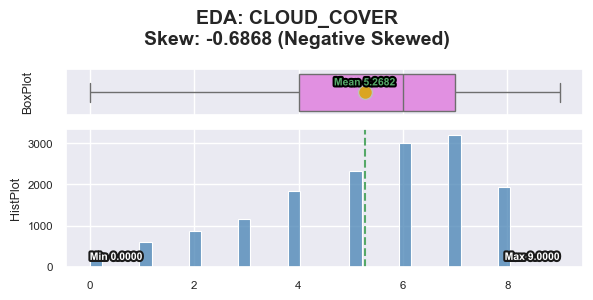

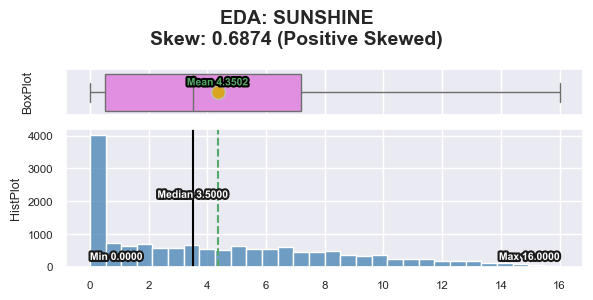

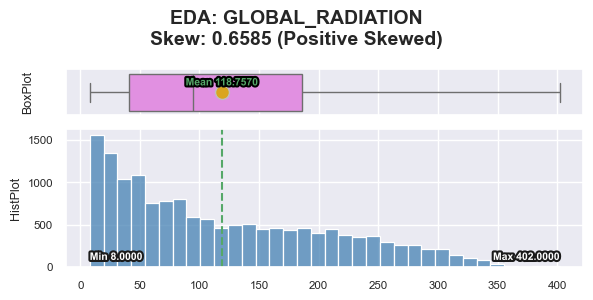

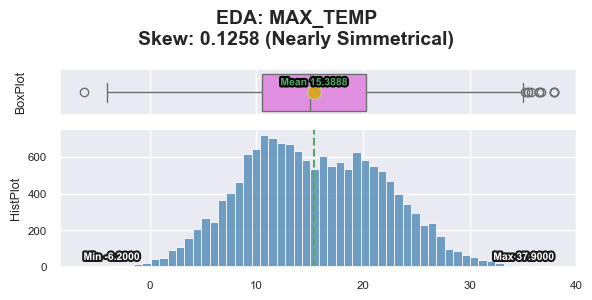

In [22]:
# Explore the continues variables features.
cols = weather.drop(['date', 'month', 'year'], axis='columns').columns
for col in cols[:4]:
    histogram_boxplot(weather[col])

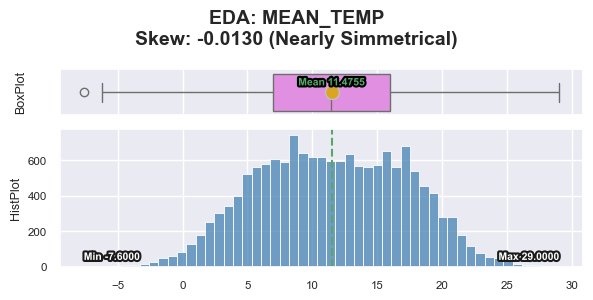

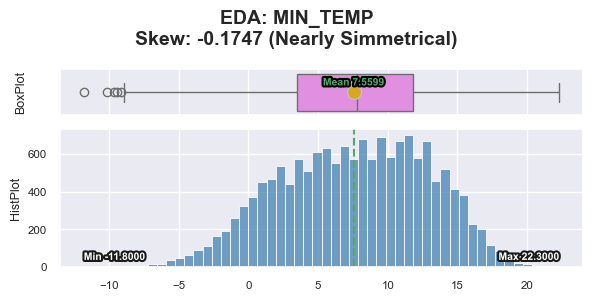

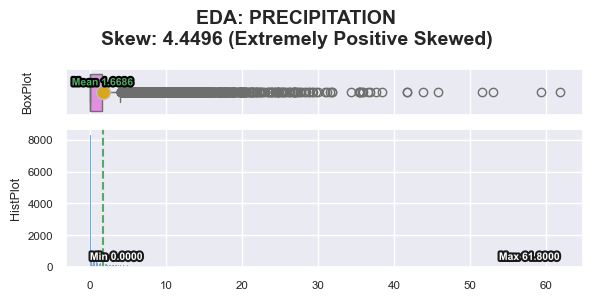

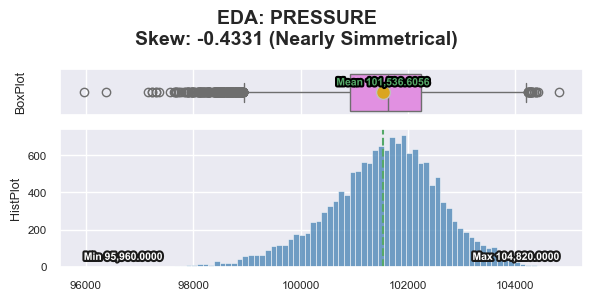

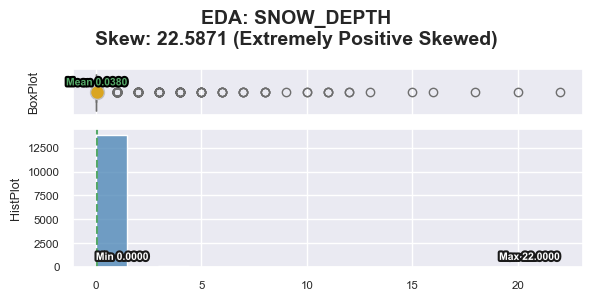

In [23]:
for col in cols[4:]:
    histogram_boxplot(weather[col])

### snow_depth column

In [24]:
# Exploring the snow_depth column
weather['snow_depth'].value_counts(dropna=False)

snow_depth
0.00000     13760
NaN          1441
1.00000        49
2.00000        24
4.00000        17
3.00000        16
5.00000         7
6.00000         5
7.00000         4
8.00000         4
11.00000        3
12.00000        2
10.00000        2
9.00000         1
13.00000        1
15.00000        1
18.00000        1
20.00000        1
22.00000        1
16.00000        1
Name: count, dtype: int64

In [25]:
weather.groupby('year').agg(
    min=('snow_depth', 'min'),
    max=('snow_depth', 'max'),
    total_days=('snow_depth', 'count'),
    registered_days=('snow_depth', lambda y: y.fillna(0).astype(bool).sum())
)

,min,max,total_days,registered_days
year,,,,
1979,0.00000,9.00000,365,18
1980,0.00000,0.00000,366,0
1981,0.00000,22.00000,365,9
1982,0.00000,18.00000,365,9
1983,0.00000,3.00000,365,1
1984,0.00000,0.00000,366,0
1985,0.00000,5.00000,365,16
1986,0.00000,8.00000,365,10
1987,0.00000,4.00000,365,7


In [26]:
# Exploring the snow_depth column by month
weather.groupby('month').agg(
    min=('snow_depth', 'min'),
    max=('snow_depth', 'max'),
    total_days=('snow_depth', 'count'),
    registered_days=('snow_depth', lambda y: y.fillna(0).astype(bool).sum())
)

,min,max,total_days,registered_days
month,,,,
1,0.00000,18.00000,1266,56
2,0.00000,12.00000,1149,48
3,0.00000,3.00000,1269,6
4,0.00000,2.00000,1181,2
5,0.00000,0.00000,1108,0
6,0.00000,0.00000,1050,0
7,0.00000,0.00000,1085,0
8,0.00000,0.00000,1085,0
9,0.00000,0.00000,1049,0


### cloud_cover column

In [27]:
# Exploring the cloud_cover column
weather['cloud_cover'].value_counts(dropna=False)

cloud_cover
7.00000    3191
6.00000    3014
5.00000    2329
8.00000    1934
4.00000    1834
3.00000    1163
2.00000     865
1.00000     609
0.00000     381
NaN          19
9.00000       2
Name: count, dtype: int64

In [28]:
# Exploring the cloud_cover column by month
weather.groupby('month').agg(
    min=('cloud_cover', 'min'),
    max=('cloud_cover', 'max'),
    total_days=('cloud_cover', 'count'),
    null_values=('cloud_cover', lambda y: y.isnull().sum())
)

,min,max,total_days,null_values
month,,,,
1,0.00000,8.00000,1300,2
2,0.00000,8.00000,1184,3
3,0.00000,8.00000,1301,1
4,0.00000,8.00000,1260,0
5,0.00000,8.00000,1302,0
6,0.00000,8.00000,1260,0
7,0.00000,8.00000,1302,0
8,0.00000,8.00000,1302,0
9,0.00000,8.00000,1259,1


### Categorical variables

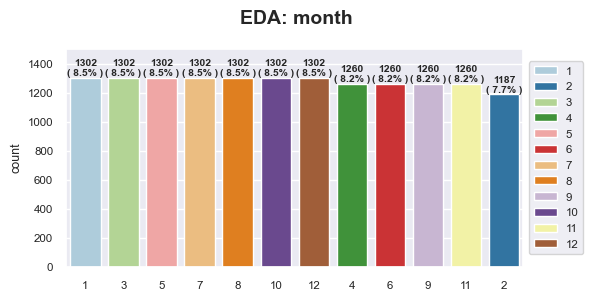

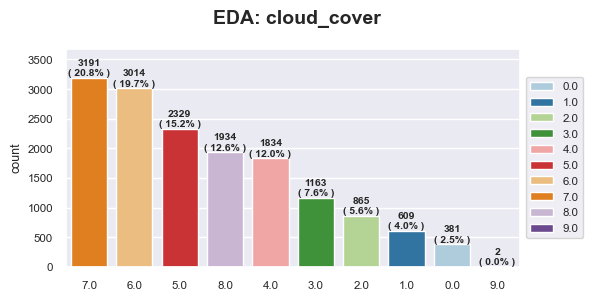

In [29]:
# Explore the categorical variables features.
cols = weather[['month', 'cloud_cover']].columns
for col in cols:
    labeled_barplot(weather[col])


### Changes on the features over time

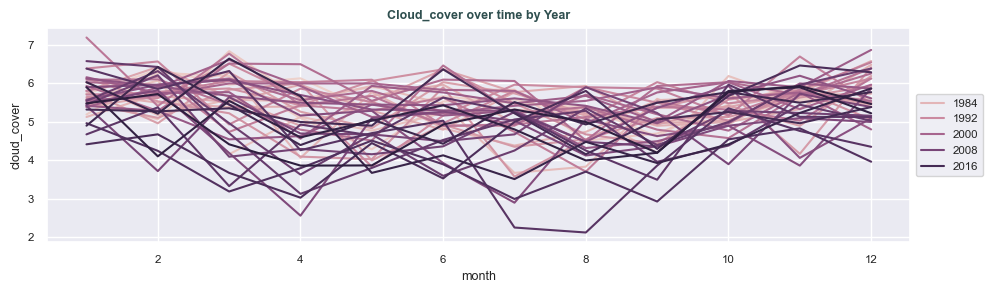

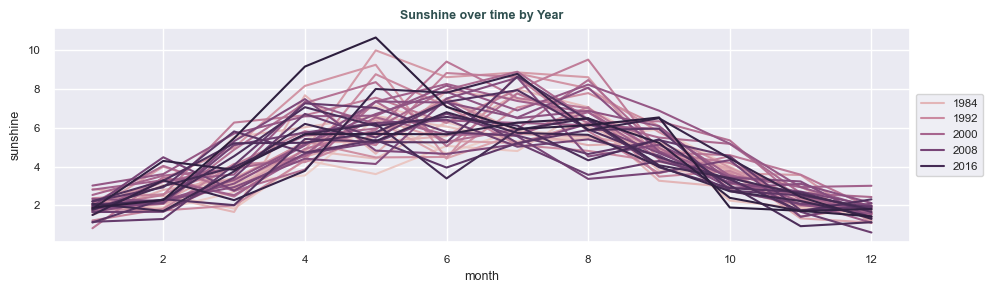

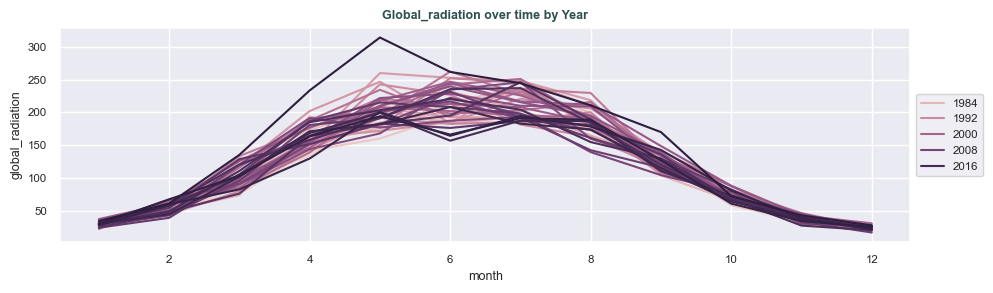

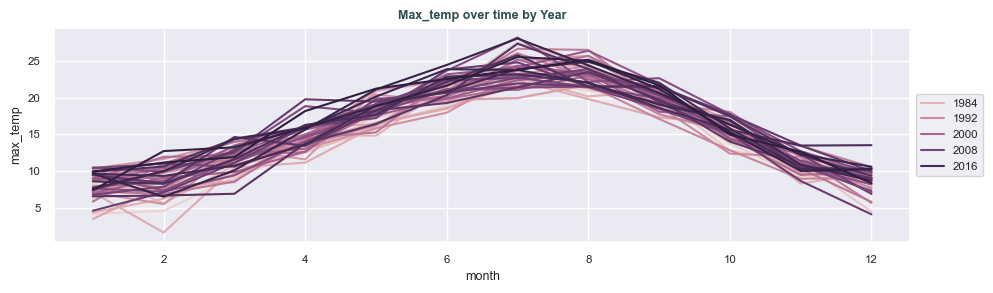

In [30]:
# Explore the changes of a feature over last documented year.
cols = weather.drop(['date', 'month', 'year'], axis='columns').columns
for col in cols[:4]:
    feature_over_time(weather.resample('ME', on='date').mean(),
                      x='month', y=col, hue='year', figsize=(10,3))

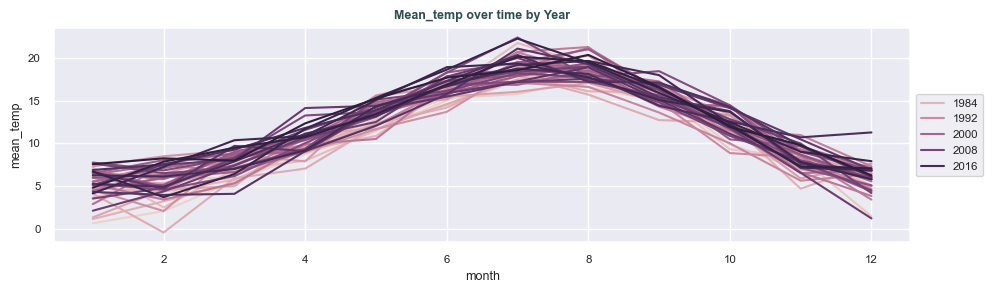

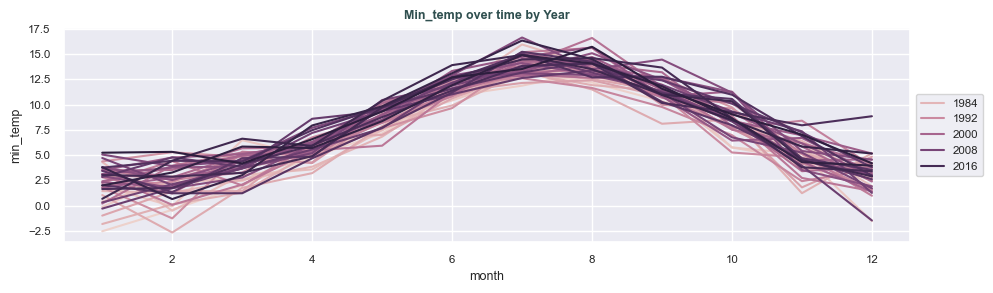

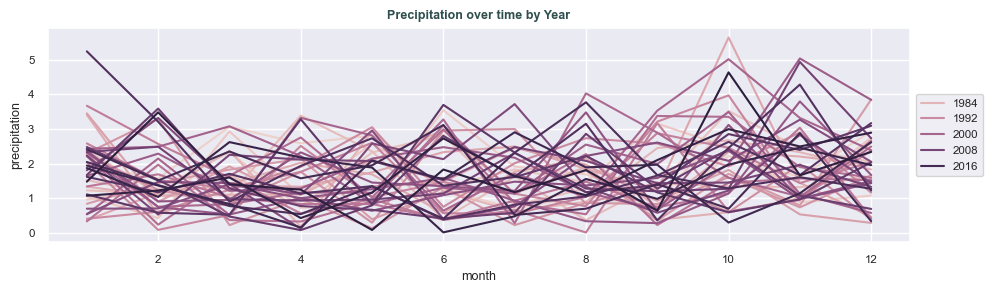

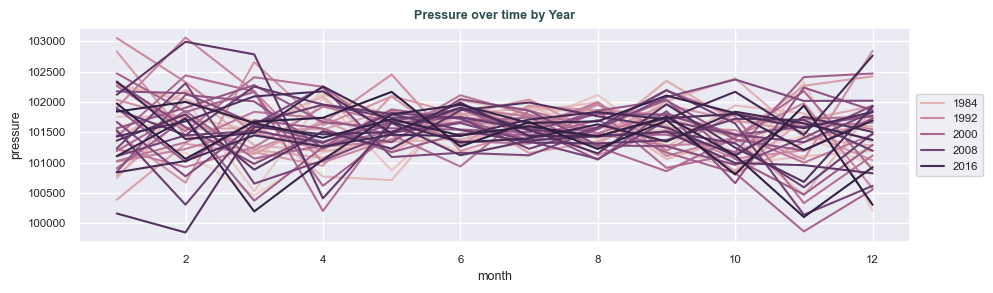

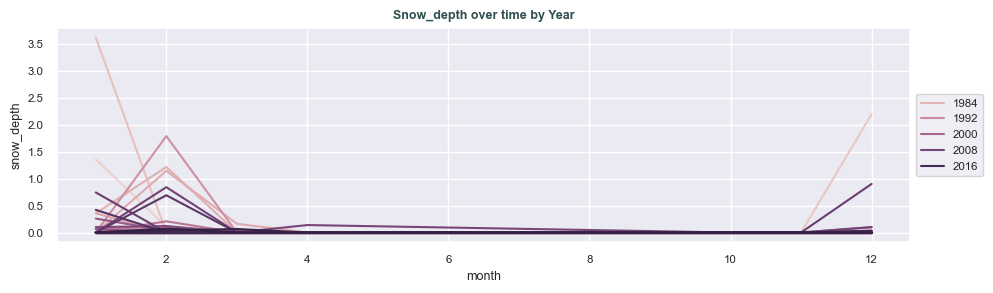

In [31]:
for col in cols[4:]:
    feature_over_time(weather.resample('ME', on='date').mean(),
                      x='month', y=col, hue='year', figsize=(10,3))

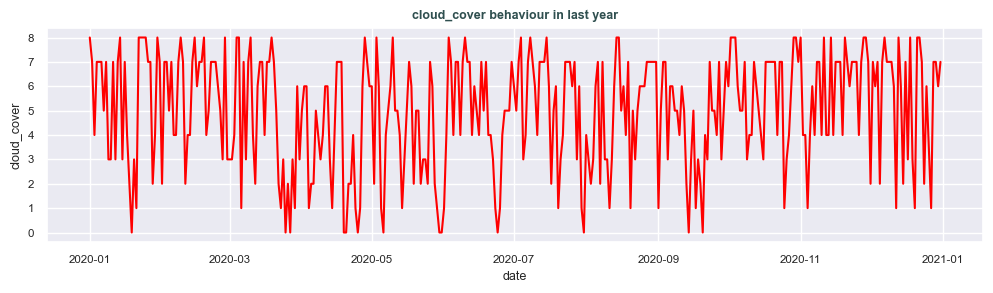

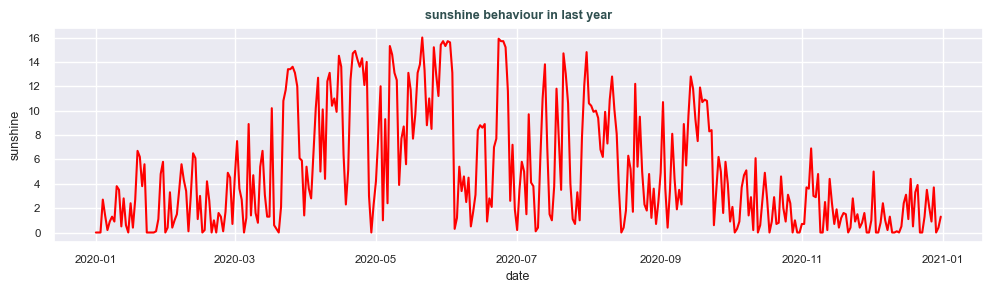

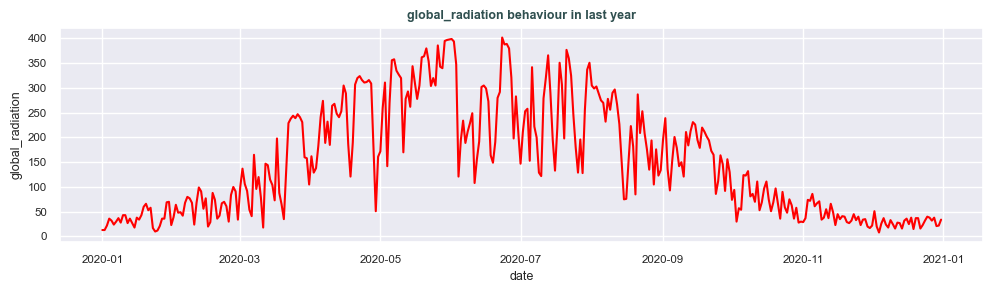

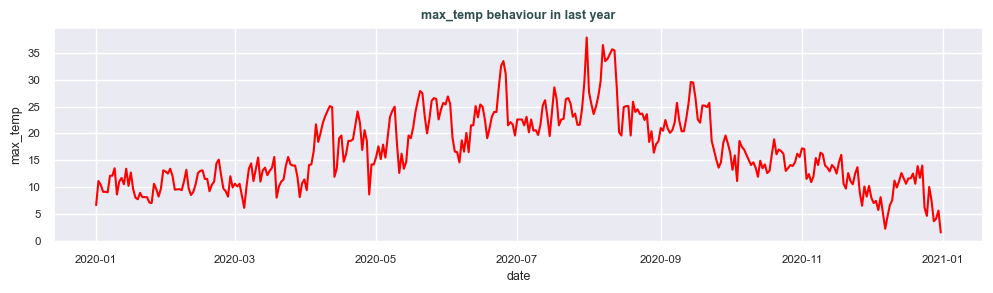

In [32]:
# Explore the changes of a feature over last documented year.
cols = weather.drop(['date', 'month', 'year'], axis='columns').columns
for col in cols[:4]:
    feature_over_time(weather[weather['date'].dt.year>2019],
                      x='date', y=col, figsize=(10,3),
                      title=f'{col} behaviour in last year')

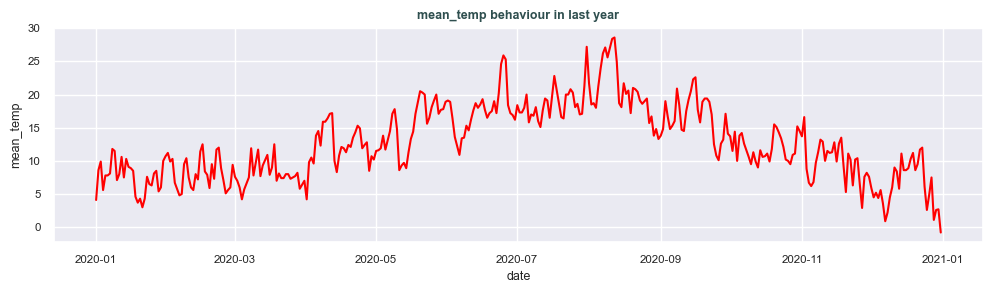

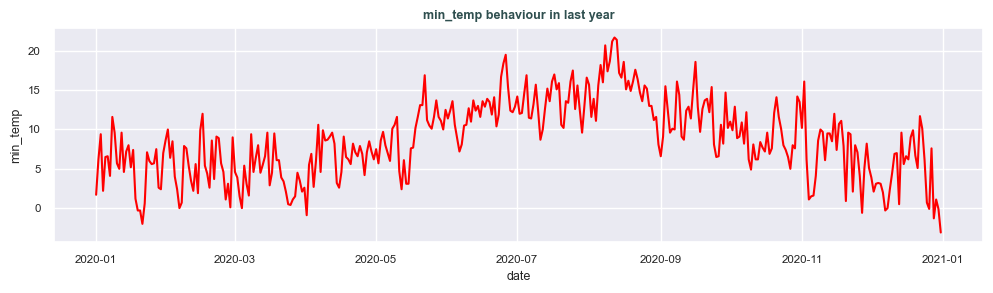

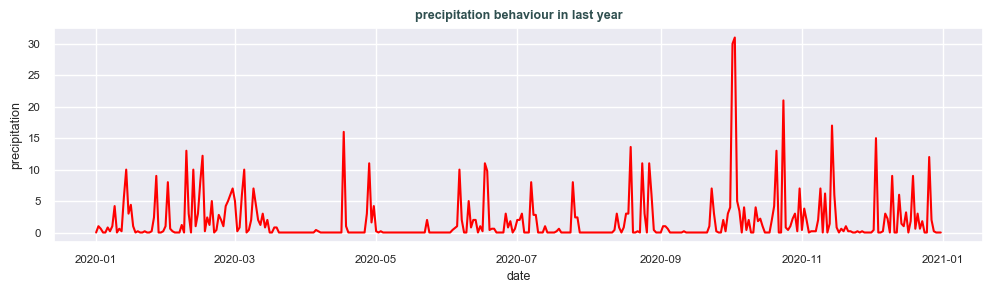

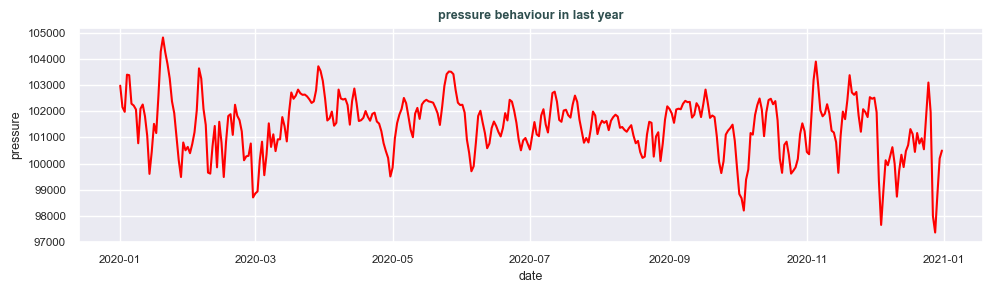

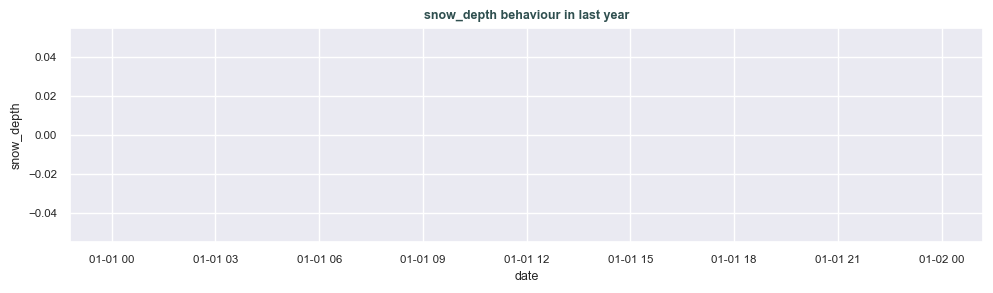

In [33]:
for col in cols[4:]:
    feature_over_time(weather[weather['date'].dt.year>2019],
                      x='date', y=col, figsize=(10,3),
                      title=f'{col} behaviour in last year')

### Correlations between features

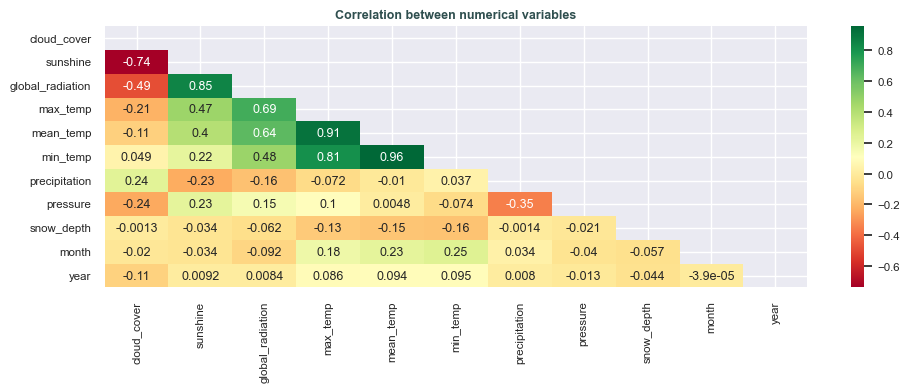

In [34]:
# look for correlations between features
corr = get_df_correlation(weather)

In [35]:
# Exploring the relation between cloud cover and temperature
weather_cloud = weather.groupby('cloud_cover').agg(
    mean_temp=('mean_temp', 'mean'),
    min_temp=('mean_temp', 'min'),
    max_temp=('mean_temp', 'max'),
    min_month=('month', 'min'),
    max_month=('month', 'max')
).reset_index()
weather_cloud

,cloud_cover,mean_temp,min_temp,max_temp,min_month,max_month
0,0.00000,12.40447,-4.40000,27.40000,1,12
1,1.00000,12.99606,-4.40000,29.00000,1,12
2,2.00000,12.00672,-4.10000,28.80000,1,12
3,3.00000,11.94582,-4.40000,28.60000,1,12
4,4.00000,11.46913,-7.60000,26.30000,1,12
5,5.00000,11.85613,-6.20000,28.70000,1,12
6,6.00000,12.00957,-4.60000,25.40000,1,12
7,7.00000,11.40657,-5.40000,27.10000,1,12
8,8.00000,9.19559,-5.20000,22.20000,1,12
9,9.00000,3.80000,1.80000,5.80000,12,12


### Relation between cloud cover and temperature

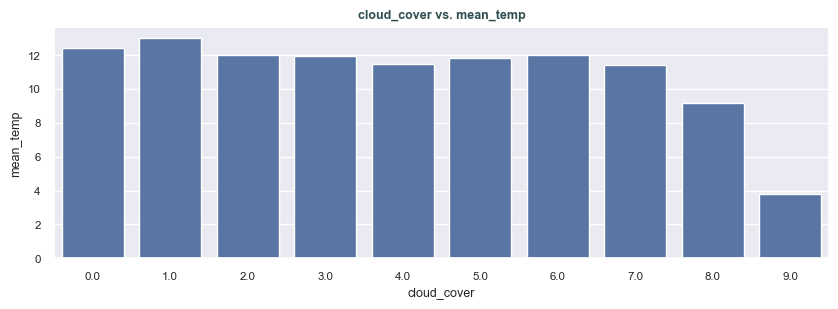

In [36]:
get_2features_barplot(weather_cloud, 'cloud_cover', 'mean_temp')

## Step 4. Feature Engineering

In [37]:
# Copy the dataframe to preserve
df = weather.copy()
target_col = 'mean_temp'
temp_cols = ['max_temp', 'mean_temp', 'min_temp']

# Setting the date as the index
df.set_index('date', inplace=True)
df.head()

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,month,year
date,,,,,,,,,,,
1979-01-01,2.00000,7.00000,52.00000,2.30000,-4.10000,-7.50000,0.40000,101900.00000,9.00000,1,1979
1979-01-02,6.00000,1.70000,27.00000,1.60000,-2.60000,-7.50000,0.00000,102530.00000,8.00000,1,1979
1979-01-03,5.00000,0.00000,13.00000,1.30000,-2.80000,-7.20000,0.00000,102050.00000,4.00000,1,1979
1979-01-04,8.00000,0.00000,13.00000,-0.30000,-2.60000,-6.50000,0.00000,100840.00000,2.00000,1,1979
1979-01-05,6.00000,2.00000,29.00000,5.60000,-0.80000,-1.40000,0.00000,102250.00000,1.00000,1,1979


### Dropping non available values for the target variable

In [38]:
df.dropna(subset=[target_col], inplace=True)
df.isnull().sum()

cloud_cover           19
sunshine               0
global_radiation      19
max_temp               0
mean_temp              0
min_temp               0
precipitation          2
pressure               4
snow_depth          1424
month                  0
year                   0
dtype: int64

### Dropping rows with null precipitation or pressure

In [39]:
# Removing rows with null precipitation, pressure
df.dropna(subset=['precipitation','pressure'], inplace=True)
df.isnull().sum()

cloud_cover           19
sunshine               0
global_radiation      19
max_temp               0
mean_temp              0
min_temp               0
precipitation          0
pressure               0
snow_depth          1419
month                  0
year                   0
dtype: int64

### Encoding the month column

In [40]:
# Encoding month feature using a sine and cosine transformation with the matching period.
# This transforme the month feature into 2 components that together encode equivalent
# information in a non-monotonic way, and more importantly without any jump between the first
# and the last value of the periodic range.
df['month_sin'] = periodic_sin_transformer(12).fit_transform(df[["month"]])["month"]
df["month_cos"] = periodic_cos_transformer(12).fit_transform(df[["month"]])["month"]

# Remove month column to avoid redundancy
df.drop('month', axis='columns', inplace=True)

# Reviewing the final result
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cloud_cover,15280.00000,5.26715,2.07001,0.00000,4.00000,6.00000,7.00000,9.00000
sunshine,15299.00000,4.35261,4.02907,0.00000,0.50000,3.50000,7.20000,16.00000
global_radiation,15280.00000,118.75995,88.89033,8.00000,41.00000,95.00000,186.00000,402.00000
max_temp,15299.00000,15.38793,6.55600,-6.20000,10.50000,15.00000,20.30000,37.90000
mean_temp,15299.00000,11.47589,5.73023,-7.60000,7.00000,11.40000,16.00000,29.00000
min_temp,15299.00000,7.55643,5.32730,-11.80000,3.50000,7.80000,11.80000,22.30000
precipitation,15299.00000,1.66977,3.74039,0.00000,0.00000,0.00000,1.60000,61.80000
pressure,15299.00000,101536.93379,1049.74537,95960.00000,100920.00000,101620.00000,102240.00000,104820.00000
snow_depth,13880.00000,0.03804,0.54602,0.00000,0.00000,0.00000,0.00000,22.00000
year,15299.00000,1999.47376,12.12188,1979.00000,1989.00000,1999.00000,2010.00000,2020.00000


### Splitting into X and y

In [41]:
# Split into X and y
X = df.drop(temp_cols, axis='columns')
y = df[target_col]

# Using the first 40 years data as the training data
X_train = X.loc[:'2020-01-01']
y_train = y.loc[:'2020-01-01']

# Using the last year data as the test data
X_test = X.loc['2020-01-01':]
y_test = y.loc['2020-01-01':]

(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((14943, 9), (14943,)), ((357, 9), (357,)))

### Imputing null values

In [42]:
X_train_imputed, X_test_imputed = X_train.copy(), X_test.copy()

# For cloud_cover and snow_depth >> Considering that nan values is equivalent to 0
const_imputer = SimpleImputer(strategy='constant', fill_value=0)
fields_imp_0 = ['cloud_cover', 'snow_depth']

X_train_imputed[fields_imp_0] = const_imputer.fit_transform(X_train_imputed[fields_imp_0])
X_test_imputed[fields_imp_0] = const_imputer.transform(X_test_imputed[fields_imp_0])

# For global_radiation >> considering their nears other days
knn_imputer = KNNImputer(n_neighbors=2, weights='uniform')
fields_imp_knn = ['global_radiation']

X_train_imputed[fields_imp_knn] = knn_imputer.fit_transform(X_train_imputed[fields_imp_knn])
X_test_imputed[fields_imp_knn] = knn_imputer.transform(X_test_imputed[fields_imp_knn])

# Reviewing null value
X_train_imputed.isnull().sum(), X_test_imputed.isnull().sum()

(cloud_cover         0
 sunshine            0
 global_radiation    0
 precipitation       0
 pressure            0
 snow_depth          0
 year                0
 month_sin           0
 month_cos           0
 dtype: int64,
 cloud_cover         0
 sunshine            0
 global_radiation    0
 precipitation       0
 pressure            0
 snow_depth          0
 year                0
 month_sin           0
 month_cos           0
 dtype: int64)

### Standardizing

In [43]:
standardizer = StandardScaler()
X_train_std = pd.DataFrame(data=standardizer.fit_transform(X_train_imputed),
                           columns=X_train_imputed.columns,
                           index=X_train_imputed.index)
X_test_std = pd.DataFrame(data=standardizer.transform(X_test_imputed),
                          columns=X_test_imputed.columns,
                          index=X_test_imputed.index)

X_train_std.head()

,cloud_cover,sunshine,global_radiation,precipitation,pressure,snow_depth,year,month_sin,month_cos
date,,,,,,,,,
1979-01-01,-1.57799,0.66444,-0.74948,-0.33869,0.34445,17.03285,-1.68809,0.71572,1.22546
1979-01-02,0.35388,-0.65728,-1.03338,-0.44572,0.94541,15.13285,-1.68809,0.71572,1.22546
1979-01-03,-0.12909,-1.08123,-1.19236,-0.44572,0.48754,7.53286,-1.68809,0.71572,1.22546
1979-01-04,1.31981,-1.08123,-1.19236,-0.44572,-0.66668,3.73286,-1.68809,0.71572,1.22546
1979-01-05,0.35388,-0.58246,-1.01066,-0.44572,0.67832,1.83286,-1.68809,0.71572,1.22546


## Step 5. Feature Selection

### Identifying the best features

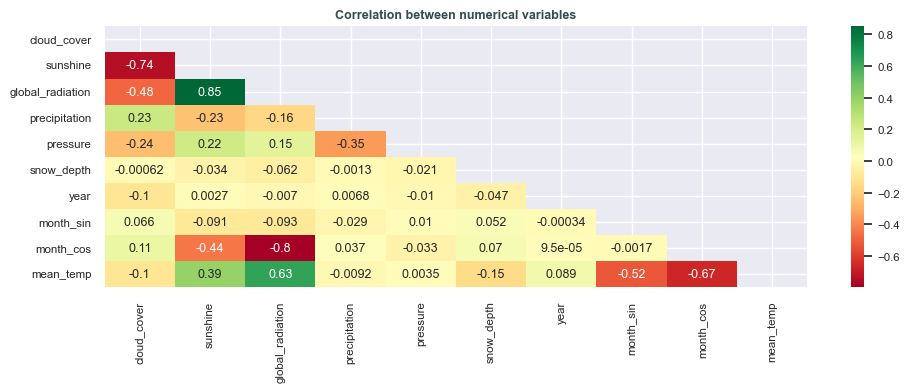

In [44]:
# look for correlations between features again
df_feature_target = pd.concat([X_train_std, y_train], axis=1)

corr = get_df_correlation(df_feature_target)

In [45]:
feature_selection = SelectKBest(score_func=f_classif, k=4).fit(X_train_std, y_train)

feature_df = pd.DataFrame({
    'Feature': feature_selection.feature_names_in_,
    'Score': feature_selection.scores_,
    'PValue': feature_selection.pvalues_
})
feature_df.sort_values('Score', ascending=False)

,Feature,Score,PValue
8,month_cos,41.00090,0.00000
5,snow_depth,39.08490,0.00000
2,global_radiation,34.16043,0.00000
7,month_sin,21.23770,0.00000
1,sunshine,11.13577,0.00000
0,cloud_cover,3.76873,0.00000
6,year,2.93303,0.00000
4,pressure,1.84811,0.00000
3,precipitation,1.28781,0.00046


In [46]:
selected_features = feature_selection.get_feature_names_out()
X_train_sel = pd.DataFrame(
    columns = selected_features,
    data = feature_selection.transform(X_train_std)
)
X_test_sel = pd.DataFrame(
    columns = selected_features,
    data = feature_selection.transform(X_test_std)
)

X_train_sel.head()

,global_radiation,snow_depth,month_sin,month_cos
0,-0.74948,17.03285,0.71572,1.22546
1,-1.03338,15.13285,0.71572,1.22546
2,-1.19236,7.53286,0.71572,1.22546
3,-1.19236,3.73286,0.71572,1.22546
4,-1.01066,1.83286,0.71572,1.22546


In [47]:
X_train_std.head()

,cloud_cover,sunshine,global_radiation,precipitation,pressure,snow_depth,year,month_sin,month_cos
date,,,,,,,,,
1979-01-01,-1.57799,0.66444,-0.74948,-0.33869,0.34445,17.03285,-1.68809,0.71572,1.22546
1979-01-02,0.35388,-0.65728,-1.03338,-0.44572,0.94541,15.13285,-1.68809,0.71572,1.22546
1979-01-03,-0.12909,-1.08123,-1.19236,-0.44572,0.48754,7.53286,-1.68809,0.71572,1.22546
1979-01-04,1.31981,-1.08123,-1.19236,-0.44572,-0.66668,3.73286,-1.68809,0.71572,1.22546
1979-01-05,0.35388,-0.58246,-1.01066,-0.44572,0.67832,1.83286,-1.68809,0.71572,1.22546


## Step 6: Machine learning training and evaluation

### Restarting the data

In [48]:
# Split into X and y
X = df.drop(temp_cols, axis='columns')
y = df[target_col]

# Using the first 40 years data as the training data
X_train = X.loc[:'2020-01-01']
y_train = y.loc[:'2020-01-01']

# Using the last year data as the test data
X_test = X.loc['2020-01-01':]
y_test = y.loc['2020-01-01':]

print(f"""
X_train and y_train shape: {(X_train.shape, y_train.shape)}
X_test and y_test shape: {(X_test.shape, y_test.shape)}

Nulls values in the dataset:
{X_train.isnull().sum()}
""")


X_train and y_train shape: ((14943, 9), (14943,))
X_test and y_test shape: ((357, 9), (357,))

Nulls values in the dataset:
cloud_cover           18
sunshine               0
global_radiation      19
precipitation          0
pressure               0
snow_depth          1063
year                   0
month_sin              0
month_cos              0
dtype: int64



### Setting the imputer transformation

In [49]:
# Define different imputer transformations
imputer = ColumnTransformer([ 
    ('const_imputer', SimpleImputer(strategy='constant', fill_value=0), ['cloud_cover', 'snow_depth']),
    ('knn_imputer', KNNImputer(n_neighbors=2, weights='uniform'), ['global_radiation']),
], remainder='passthrough')

imputer

ColumnTransformer(remainder='passthrough',
                  transformers=[('const_imputer',
                                 SimpleImputer(fill_value=0,
                                               strategy='constant'),
                                 ['cloud_cover', 'snow_depth']),
                                ('knn_imputer', KNNImputer(n_neighbors=2),
                                 ['global_radiation'])])

In [64]:
# Define the feature selection estimator
feature_selection = SelectKBest(score_func=f_classif, k=9)

feature_selection

SelectKBest(k=9)

### Trying different models

In [65]:
models = {
    LinearRegression: {'fit_intercept': [True, False]},
    DecisionTreeRegressor: {'criterion': ['squared_error', 'absolute_error'],
                            'max_features': ['sqrt', 'log2', None],
                            'max_depth': [3, 5, 10],
                            'random_state': [SEED]},
    RandomForestRegressor: {'max_features': ['sqrt', 'log2', None, 1],
                            'max_depth': [3, 5, 10],
                            'random_state': [SEED]}
}

# Set experiment
experiment = mlflow.set_experiment(experiment_name)

trained_model = []
for model, param_grid in models.items():
    # Grid search
    model_name = str(model()).upper()[:-2]
    print(f'\nPIPELINE FOR {model_name}:')

    # Parameter list
    params = list(ParameterGrid(param_grid))
    print(f'Total param combination: {len(params)}\n')
    for param in params:
        # Start a run
        run = mlflow.start_run()
        
        # Pipeline configuration
        pipe = make_pipeline(imputer, StandardScaler(), feature_selection, model(**param))

        # Training the model
        pipe.fit(X_train, y_train)

        # Predicting values
        y_pred = pipe.predict(X_test)
        mse, rmse, mae, r2 = calculate_regressionmetrics(y_test, y_pred)

        # Evaluating the model
        trained_model.append({
            'run_id': run.info.run_id,
            'model_name': str(model(**param)),
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2':r2
        })

        # Tracking the model and score
        mlflow.sklearn.log_model(
            sk_model=pipe,
            artifact_path='model',
        )
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)

        # End run
        mlflow.end_run()


result = pd.DataFrame(trained_model)


PIPELINE FOR LINEARREGRESSION:
Total param combination: 2


PIPELINE FOR DECISIONTREEREGRESSOR:
Total param combination: 18


PIPELINE FOR RANDOMFORESTREGRESSOR:
Total param combination: 12



In [66]:
result[result.r2 >= 0.7]

,run_id,model_name,mse,rmse,mae,r2
24,1699ef9ff6684a84b0a150e4fd10b275,"RandomForestRegressor(max_depth=5, max_feature...",9.08914,3.01482,2.38975,0.70178
25,03cb59e65574454cac8e3fc09ca8e0c8,"RandomForestRegressor(max_depth=5, max_feature...",9.08914,3.01482,2.38975,0.70178
28,93ce869d7f8346539f74e62b71643e0f,"RandomForestRegressor(max_depth=10, max_featur...",8.60346,2.93317,2.35909,0.71772
29,aeaff489c4cc42629a24cdfb0532034e,"RandomForestRegressor(max_depth=10, max_featur...",8.60346,2.93317,2.35909,0.71772
31,9d77046eee4c460d9e4da80ffdfe5c9e,"RandomForestRegressor(max_depth=10, max_featur...",8.81968,2.96980,2.33878,0.71062


## Step 7: Searching your logged results

### Filtering the best metrics result

In [67]:
score_filter = "metrics.r2 > 0.70"
df = mlflow.search_runs(filter_string=score_filter, order_by=["metrics.r2 DESC"])
df

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.r2,metrics.mae,metrics.mse,metrics.rmse,tags.mlflow.source.name,tags.mlflow.log-model.history,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName
0,aeaff489c4cc42629a24cdfb0532034e,340845070720471291,FINISHED,file:///C:/Users/Jacqueline/Documents/projects...,2024-06-14 17:58:13.987000+00:00,2024-06-14 17:58:17.217000+00:00,0.71772,2.35909,8.60346,2.93317,C:\ProgramData\anaconda3\envs\ml\Lib\site-pack...,"[{""run_id"": ""aeaff489c4cc42629a24cdfb0532034e""...",Jacqueline,LOCAL,unique-turtle-456
1,93ce869d7f8346539f74e62b71643e0f,340845070720471291,FINISHED,file:///C:/Users/Jacqueline/Documents/projects...,2024-06-14 17:58:10.770000+00:00,2024-06-14 17:58:13.977000+00:00,0.71772,2.35909,8.60346,2.93317,C:\ProgramData\anaconda3\envs\ml\Lib\site-pack...,"[{""run_id"": ""93ce869d7f8346539f74e62b71643e0f""...",Jacqueline,LOCAL,valuable-jay-348
2,9d77046eee4c460d9e4da80ffdfe5c9e,340845070720471291,FINISHED,file:///C:/Users/Jacqueline/Documents/projects...,2024-06-14 17:58:21.701000+00:00,2024-06-14 17:58:24.548000+00:00,0.71062,2.33878,8.81968,2.96980,C:\ProgramData\anaconda3\envs\ml\Lib\site-pack...,"[{""run_id"": ""9d77046eee4c460d9e4da80ffdfe5c9e""...",Jacqueline,LOCAL,painted-sponge-397
3,6fbdf20f36f24033a298fcce981940f5,340845070720471291,FINISHED,file:///C:/Users/Jacqueline/Documents/projects...,2024-06-14 16:45:02.465000+00:00,2024-06-14 16:45:04.930000+00:00,0.70810,2.38525,8.89649,2.98270,C:\ProgramData\anaconda3\envs\ml\Lib\site-pack...,"[{""run_id"": ""6fbdf20f36f24033a298fcce981940f5""...",Jacqueline,LOCAL,sneaky-ox-162
4,0c2923f83e304b0d9f7f8ad9ed177e8c,340845070720471291,FINISHED,file:///C:/Users/Jacqueline/Documents/projects...,2024-06-14 16:43:55.774000+00:00,2024-06-14 16:43:58.219000+00:00,0.70810,2.38525,8.89649,2.98270,C:\ProgramData\anaconda3\envs\ml\Lib\site-pack...,"[{""run_id"": ""0c2923f83e304b0d9f7f8ad9ed177e8c""...",Jacqueline,LOCAL,nosy-bass-40
5,03cb59e65574454cac8e3fc09ca8e0c8,340845070720471291,FINISHED,file:///C:/Users/Jacqueline/Documents/projects...,2024-06-14 17:58:01.861000+00:00,2024-06-14 17:58:04.689000+00:00,0.70178,2.38975,9.08914,3.01482,C:\ProgramData\anaconda3\envs\ml\Lib\site-pack...,"[{""run_id"": ""03cb59e65574454cac8e3fc09ca8e0c8""...",Jacqueline,LOCAL,thoughtful-stork-206
6,1699ef9ff6684a84b0a150e4fd10b275,340845070720471291,FINISHED,file:///C:/Users/Jacqueline/Documents/projects...,2024-06-14 17:57:59.042000+00:00,2024-06-14 17:58:01.851000+00:00,0.70178,2.38975,9.08914,3.01482,C:\ProgramData\anaconda3\envs\ml\Lib\site-pack...,"[{""run_id"": ""1699ef9ff6684a84b0a150e4fd10b275""...",Jacqueline,LOCAL,burly-fish-373
7,098e822d669d45be8369f287fa7d661f,340845070720471291,FINISHED,file:///C:/Users/Jacqueline/Documents/projects...,2024-06-14 16:42:17.033000+00:00,2024-06-14 16:42:19.550000+00:00,0.70102,2.39671,9.11243,3.01868,C:\ProgramData\anaconda3\envs\ml\Lib\site-pack...,"[{""run_id"": ""098e822d669d45be8369f287fa7d661f""...",Jacqueline,LOCAL,delightful-koi-285
8,c1cb3ca4e7ea424589ce10328e7995fe,340845070720471291,FINISHED,file:///C:/Users/Jacqueline/Documents/projects...,2024-06-14 16:42:24.470000+00:00,2024-06-14 16:42:26.984000+00:00,0.70102,2.39671,9.11243,3.01868,C:\ProgramData\anaconda3\envs\ml\Lib\site-pack...,"[{""run_id"": ""c1cb3ca4e7ea424589ce10328e7995fe""...",Jacqueline,LOCAL,spiffy-stoat-716
9,83d11cff9f8c422c9e04f2436776fe4b,340845070720471291,FINISHED,file:///C:/Users/Jacqueline/Documents/projects...,2024-06-14 16:42:09.528000+00:00,2024-06-14 16:42:12.047000+00:00,0.70102,2.39671,9.11243,3.01868,C:\ProgramData\anaconda3\envs\ml\Lib\site-pack...,"[{""run_id"": ""83d11cff9f8c422c9e04f2436776fe4b""...",Jacqueline,LOCAL,mercurial-colt-741


### Loading the best model

In [68]:
run_id = df['run_id'].loc[0]
print("Run ID:", run_id)

loaded_model = mlflow.sklearn.load_model(f'runs:/{run_id}/model')
print('Loaded model from MLFlow Tracking:', loaded_model)

Run ID: aeaff489c4cc42629a24cdfb0532034e
Loaded model from MLFlow Tracking: Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('const_imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['cloud_cover',
                                                   'snow_depth']),
                                                 ('knn_imputer',
                                                  KNNImputer(n_neighbors=2),
                                                  ['global_radiation'])])),
                ('standardscaler', StandardScaler()),
                ('selectkbest', SelectKBest(k=9)),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=10, max_features='log2',
                       